# Anomaly Detection Decision Rules
Once we have a good forecast, it is time to decide when to send alerts to developers. The most straightforward approach would be to simply send an alert when there is large discrepancy between the real data and the forecast. However, due to noise and small errors in the forecasting model, this decision rule is too coarse for meaning anomaly detection. 


## Step 1: Identify a time series

Below we have a time series taken from http_request_duration_microseconds quantile data. This time series is from a specific target with the following metadata:

{'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'hostname': 'free-stg-node-compute-e0756', 'instance': 'ip-172-31-76-144.us-east-2.compute.internal', 'job': 'kubernetes-nodes-exporter', 'kubernetes_io_hostname': 'ip-172-31-76-144.us-east-2.compute.internal', 'logging_infra_fluentd': 'true', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.99', 'region': 'us-east-2', 'type': 'compute'}

Note that this graph displays a dummy timestamp (in chronological order) vs. value. We are working with dummy timestamps because the actual data has gaps and dropouts. We ignore these inconsistencies in timestamps for now.

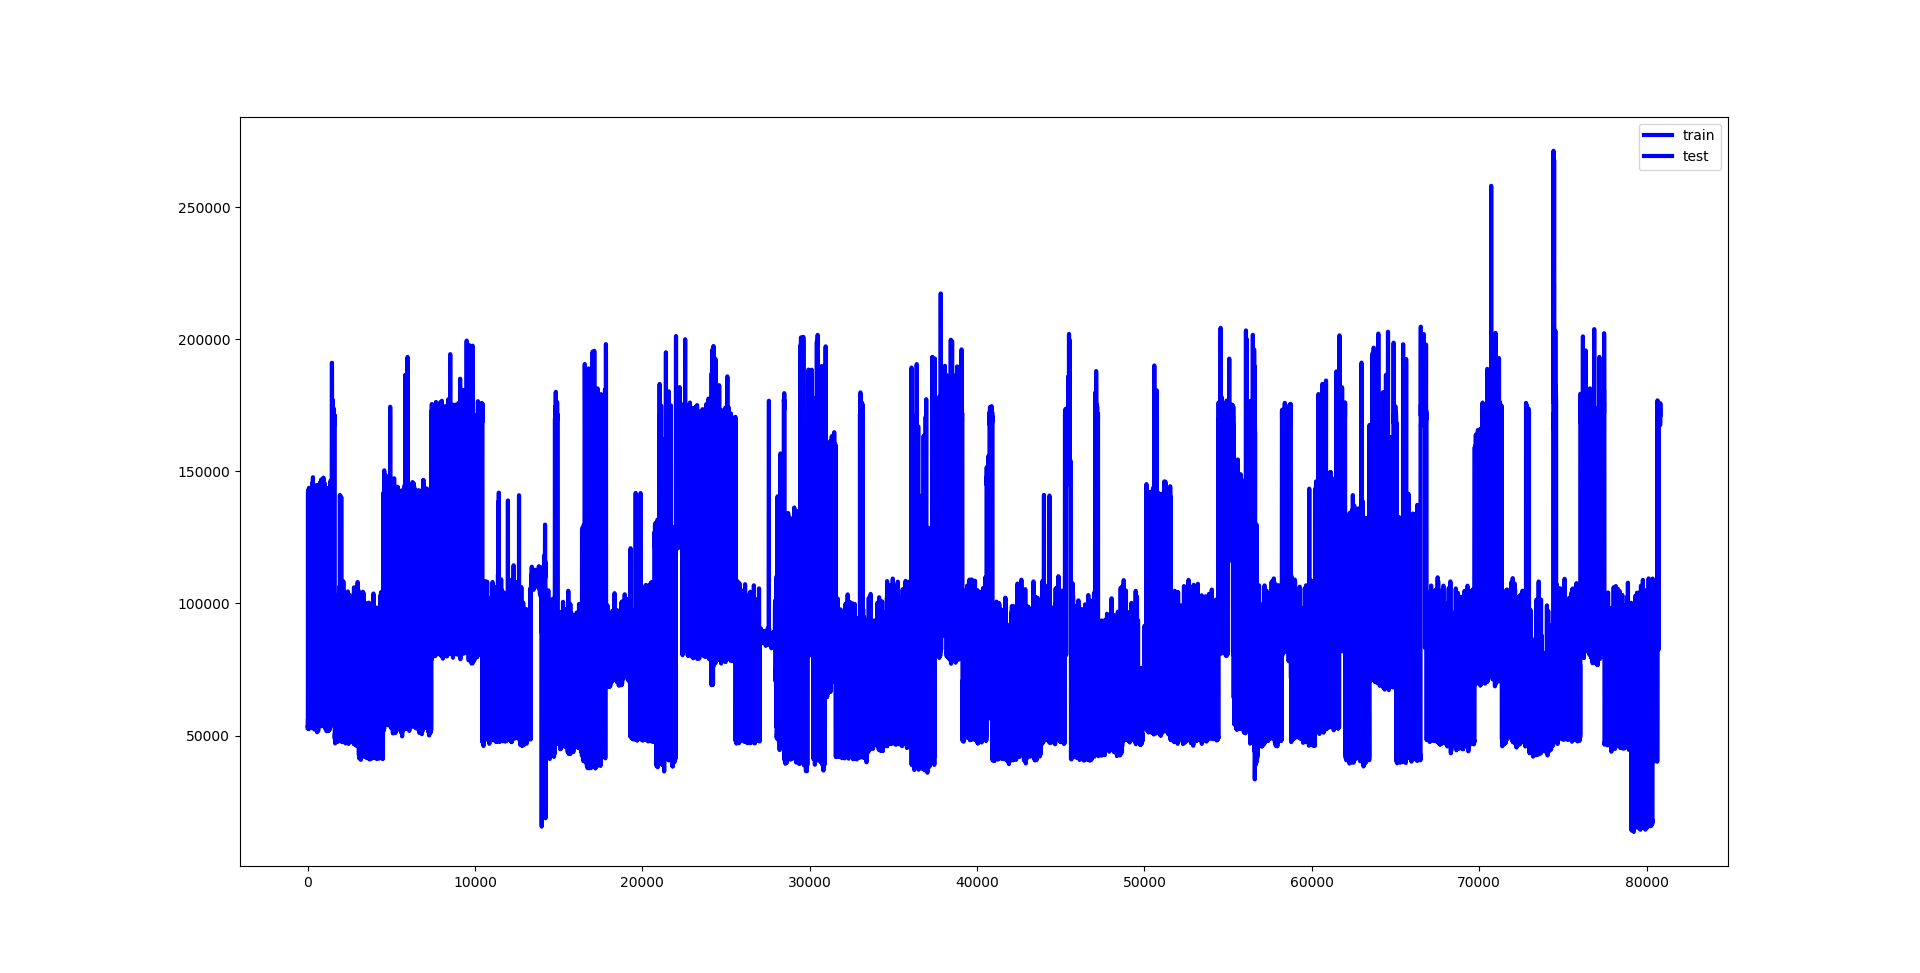

In [1]:
from IPython.display import Image
Image(filename='imgs/example_ts.png')

## Step 2: Training

Once we've identified a time series, it is time to forecast. We begin by separating the data into training *(70% of data)* and testing *(30% of data)* sets.

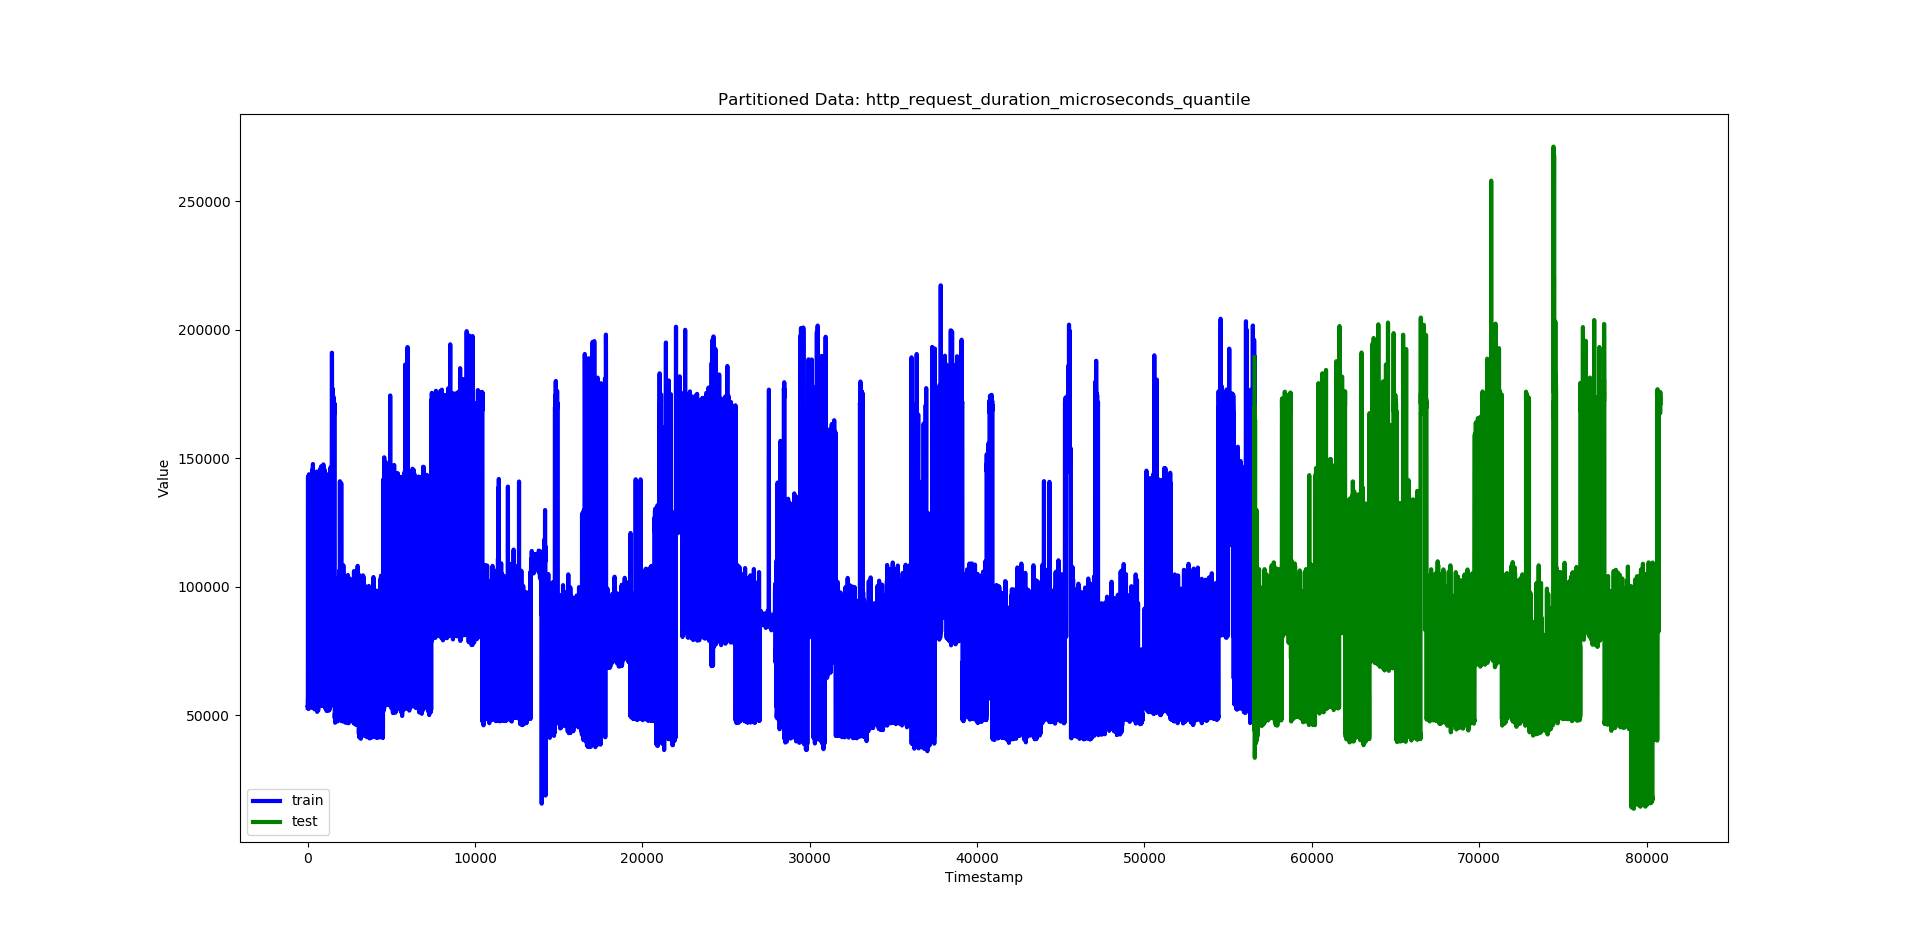

In [2]:
Image(filename='imgs/partitioned_ts.png')

#### Fourier Extrapolation

We use Fourier Analysis to decompose the signal into harmonics. Next, we create a forecast by taking these harmonics and adding them together to reconstruct a forecast.

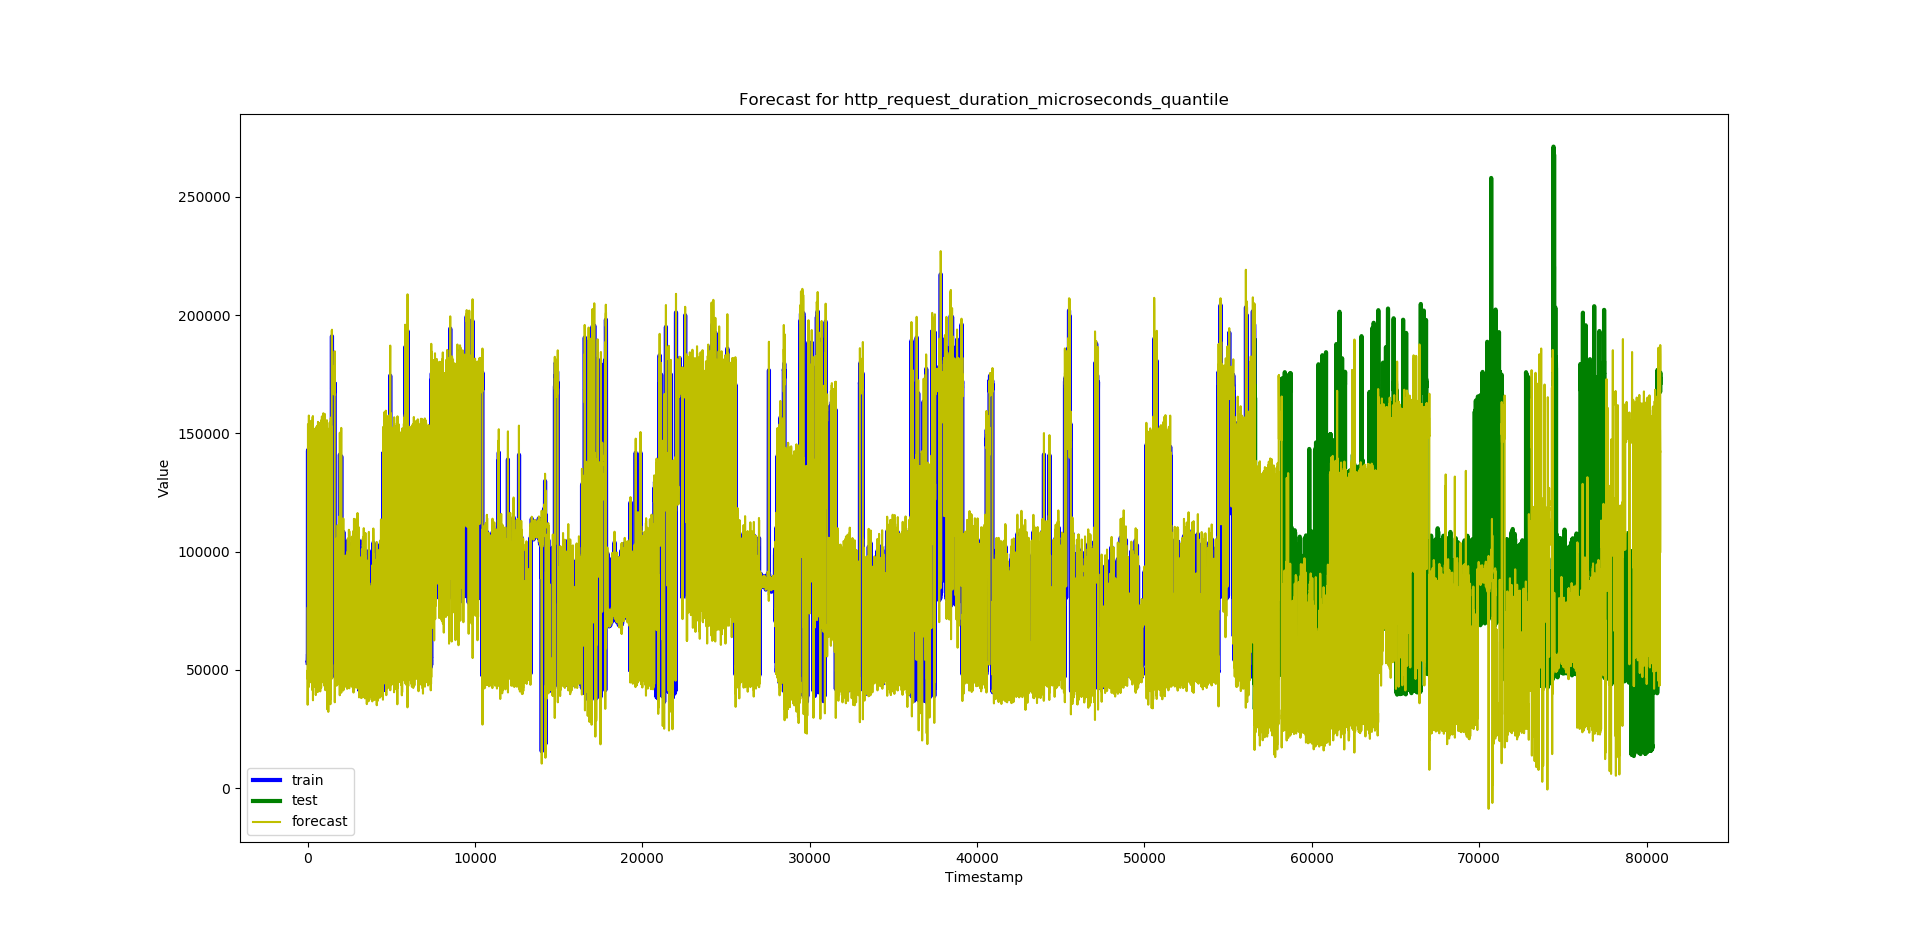

In [3]:
Image(filename='imgs/fourier_extrapolation.png')

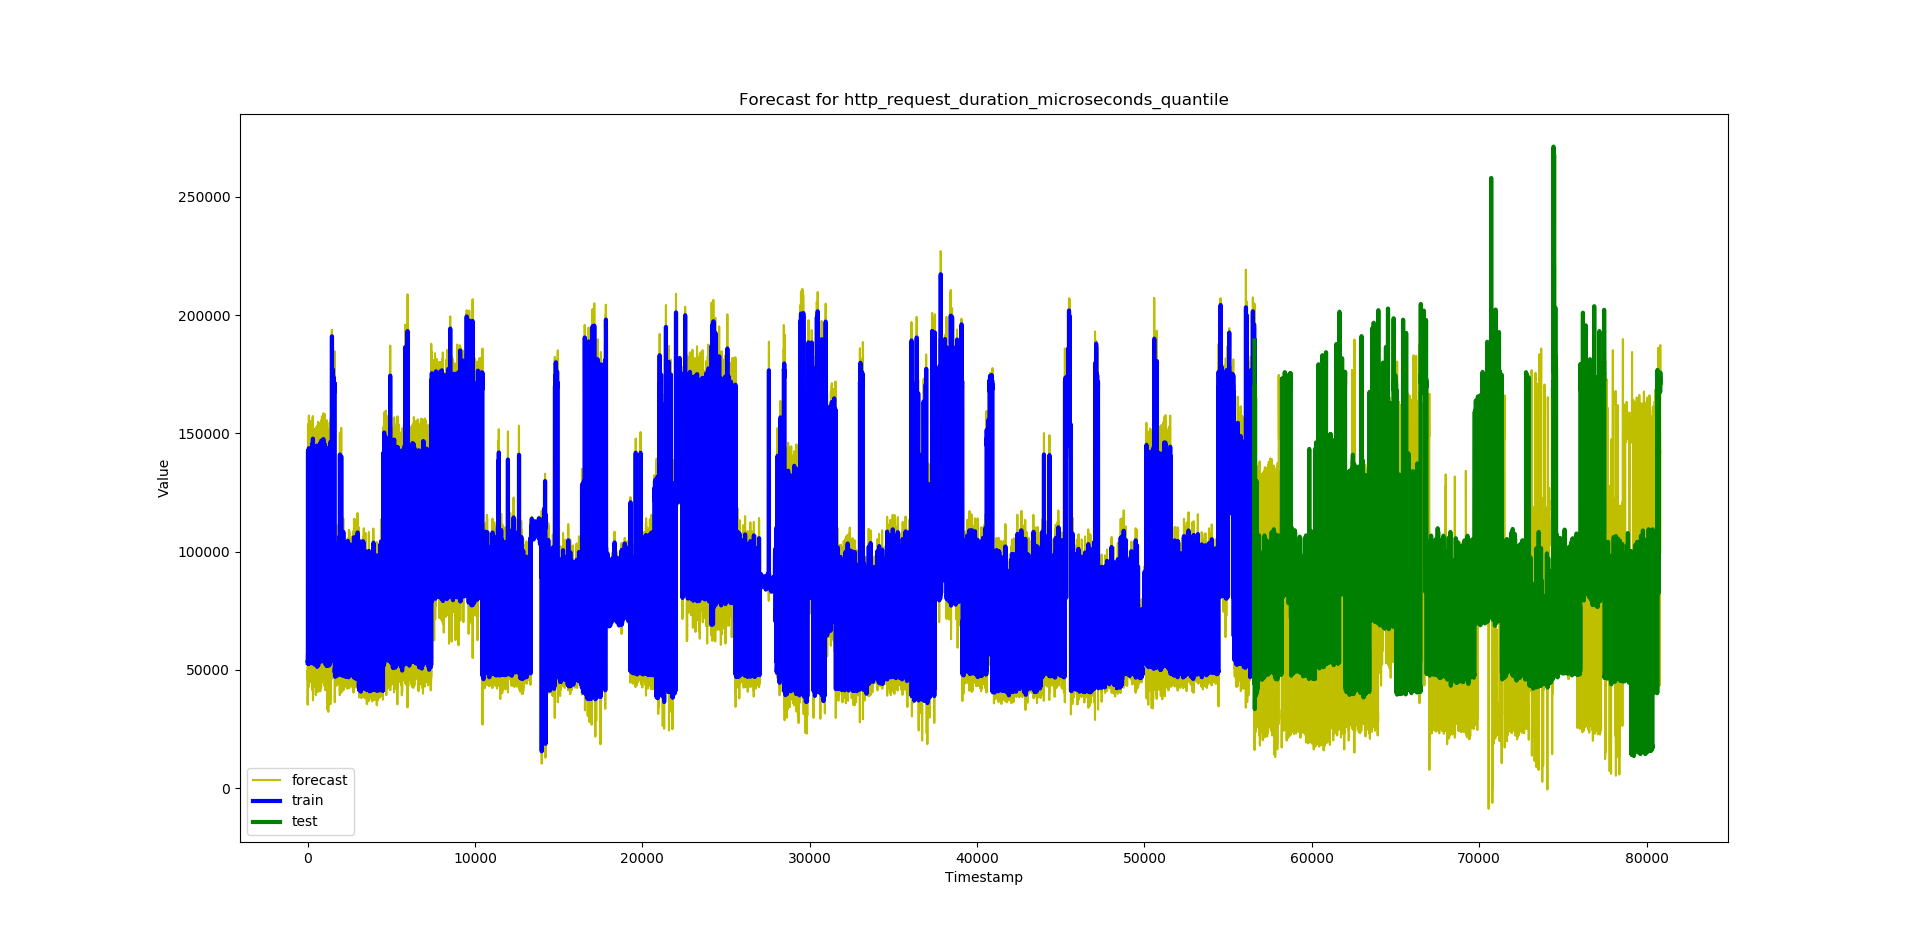

In [4]:
Image(filename='imgs/fourier_extrapolation_behind.png')

### Anomaly Detection Decision Rules

Once we have an accurate forecast, it is time to decide when to send alerts to developers. It turns out that there are quite a few hidden complexities when it comes to sending alerts. We want to send a reasonable amount of alerts to the developer when there are significant changes in the behavior of the time series. However, this may not be as simple as a quick threshhold when the forecast and the real data diverge.

There are 3 main sources of variation between the forecast and the real data:
1. The data is anomalous
2. The data is very noisy
3. The forecast does not have a good prediction

As a developer, we only care about the first issue. As much as possible, we want to eliminate un-actionable alerts relating to 2 and 3, and get meaningful alerting when something is really wrong with the system.

This brings us to the realm of decision rules. We have identified 2 forms of anomaly detection rules to apply to this system:
* The Accumulator
* The Tail Probability

**References:**

https://storage.googleapis.com/pub-tools-public-publication-data/pdf/dfd834facc9460163438b94d53b36f51bb5ea952.pdf

https://arxiv.org/pdf/1607.02480.pdf


#### The Accumulator

The accumulator detection rules is based on the assumption that anomalous data is persistent. Rather than detecting anomalies point-wise, we have a running counter which increments when a point is flagged as anomalous and decremenets by 2 when a normal point is detected. If the counter reaches a certain threshhold value, then we raise a flag.

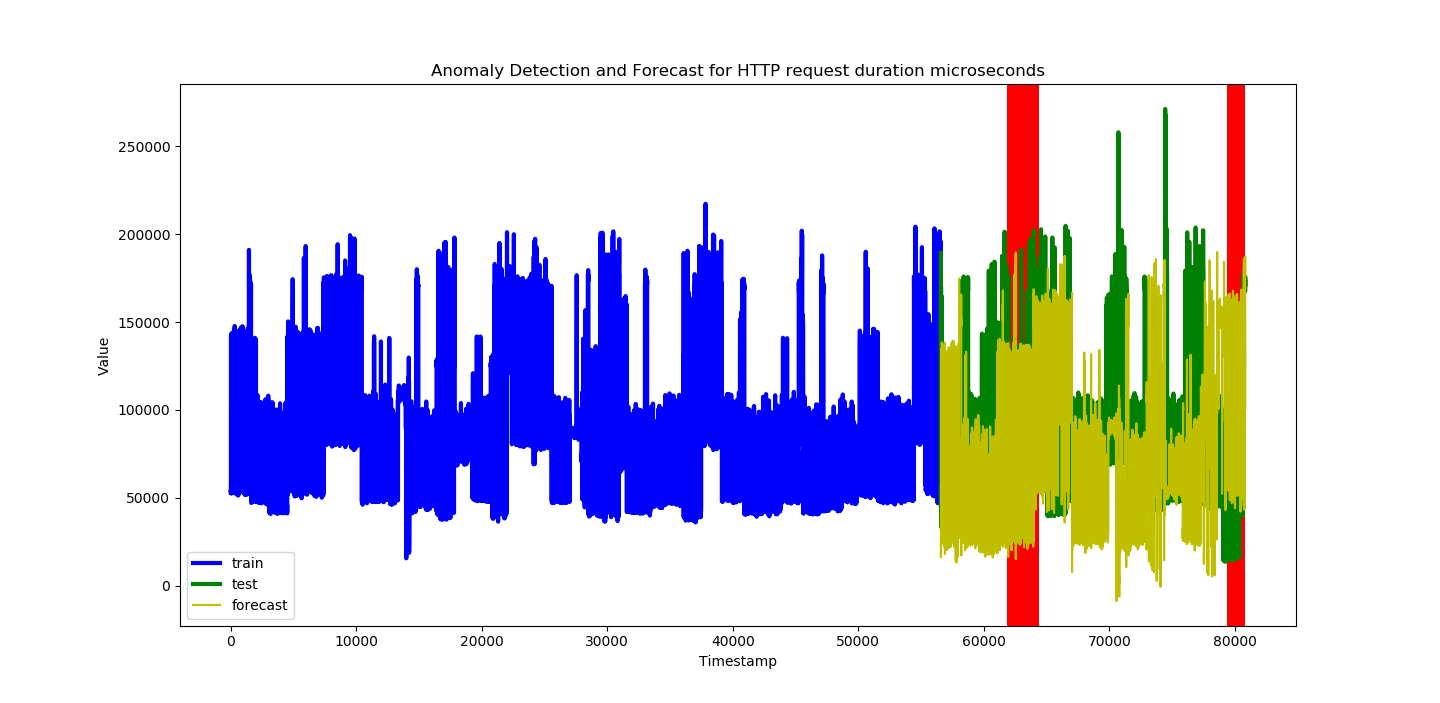

In [5]:
Image(filename='imgs/detect_anomaly_accumulator.png')

#### The Tail Probability

This anomaly detection rule uses the idea that the recent past's noise is comparable to the current noise. Using the gaussian noise assumption, we calculate the tail probability that that the mean of the current values is comparable to the values in the recent past.

The implementation can be found in this paper:
https://arxiv.org/pdf/1607.02480.pdf

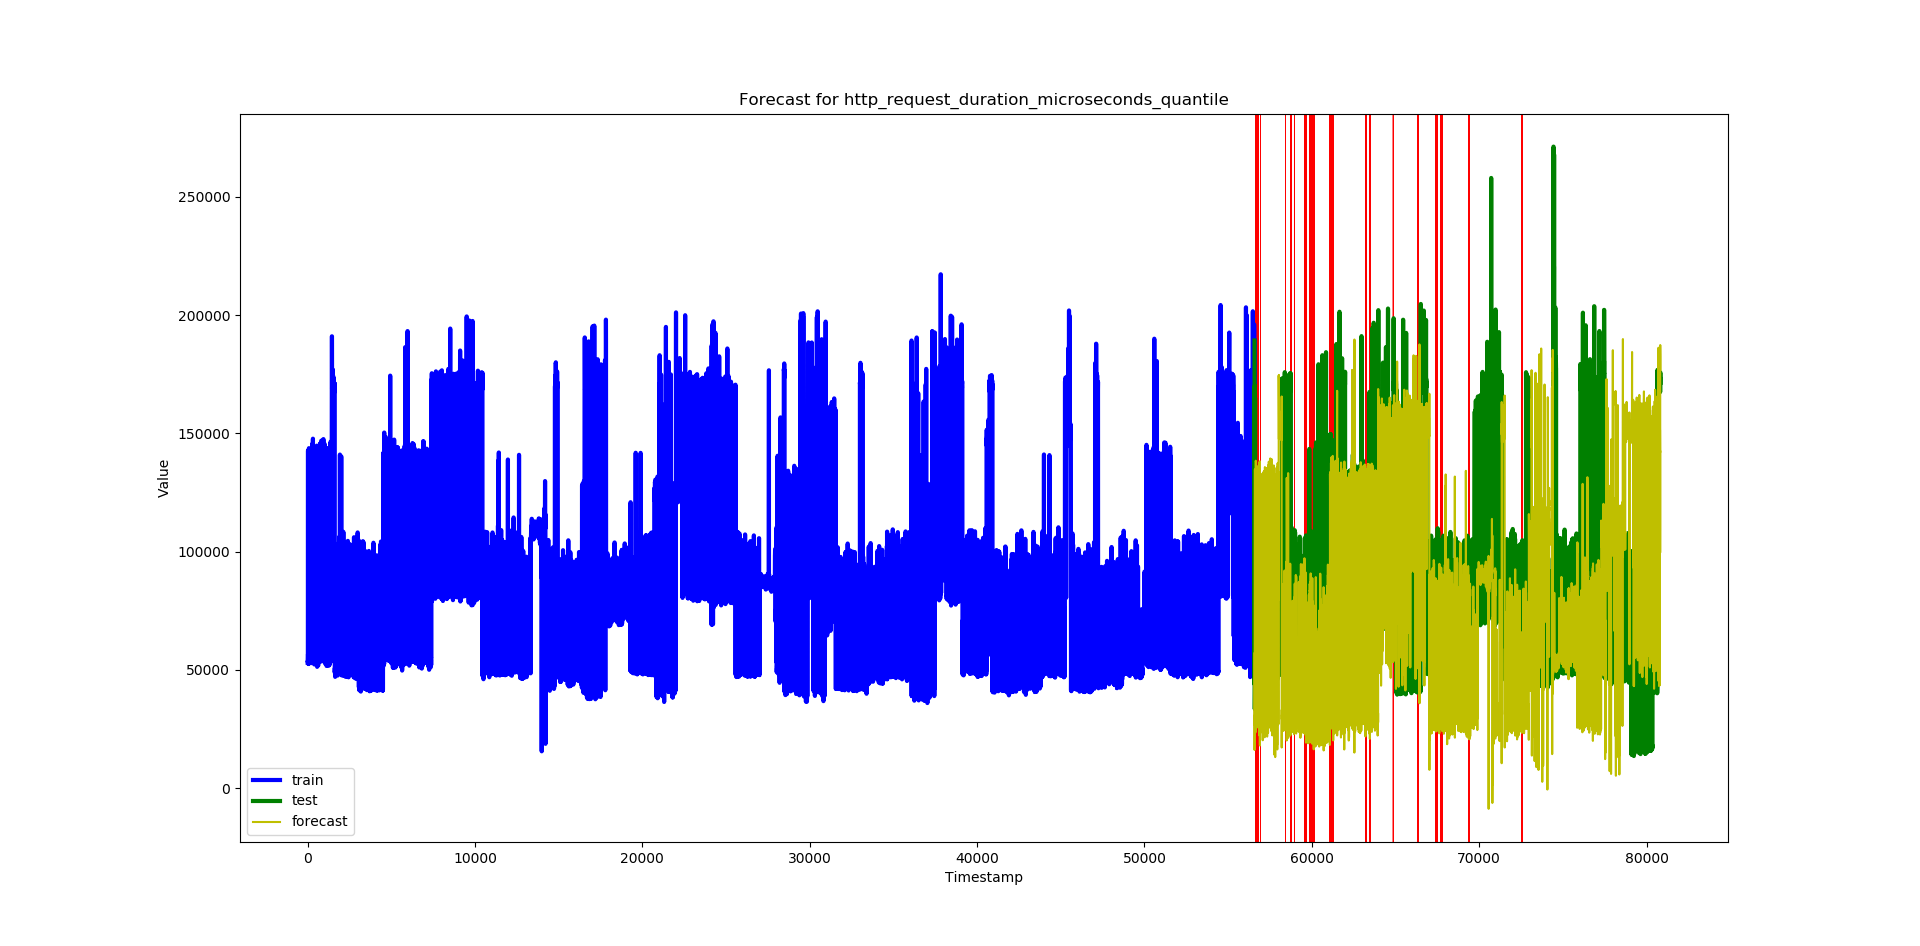

In [6]:
Image(filename='imgs/detect_anomaly_tail_prob.png')

#### Combined Anomaly Detection Decisions

If we take the intersection of both anomaly detection rules, we come up with the following results. It looks like this approach is most robust to false positives, although, it might not take into account all anomalies.

In the paper, the results point to this being the most accurate decision rule, although further tests on our data are needed for conclusive results.

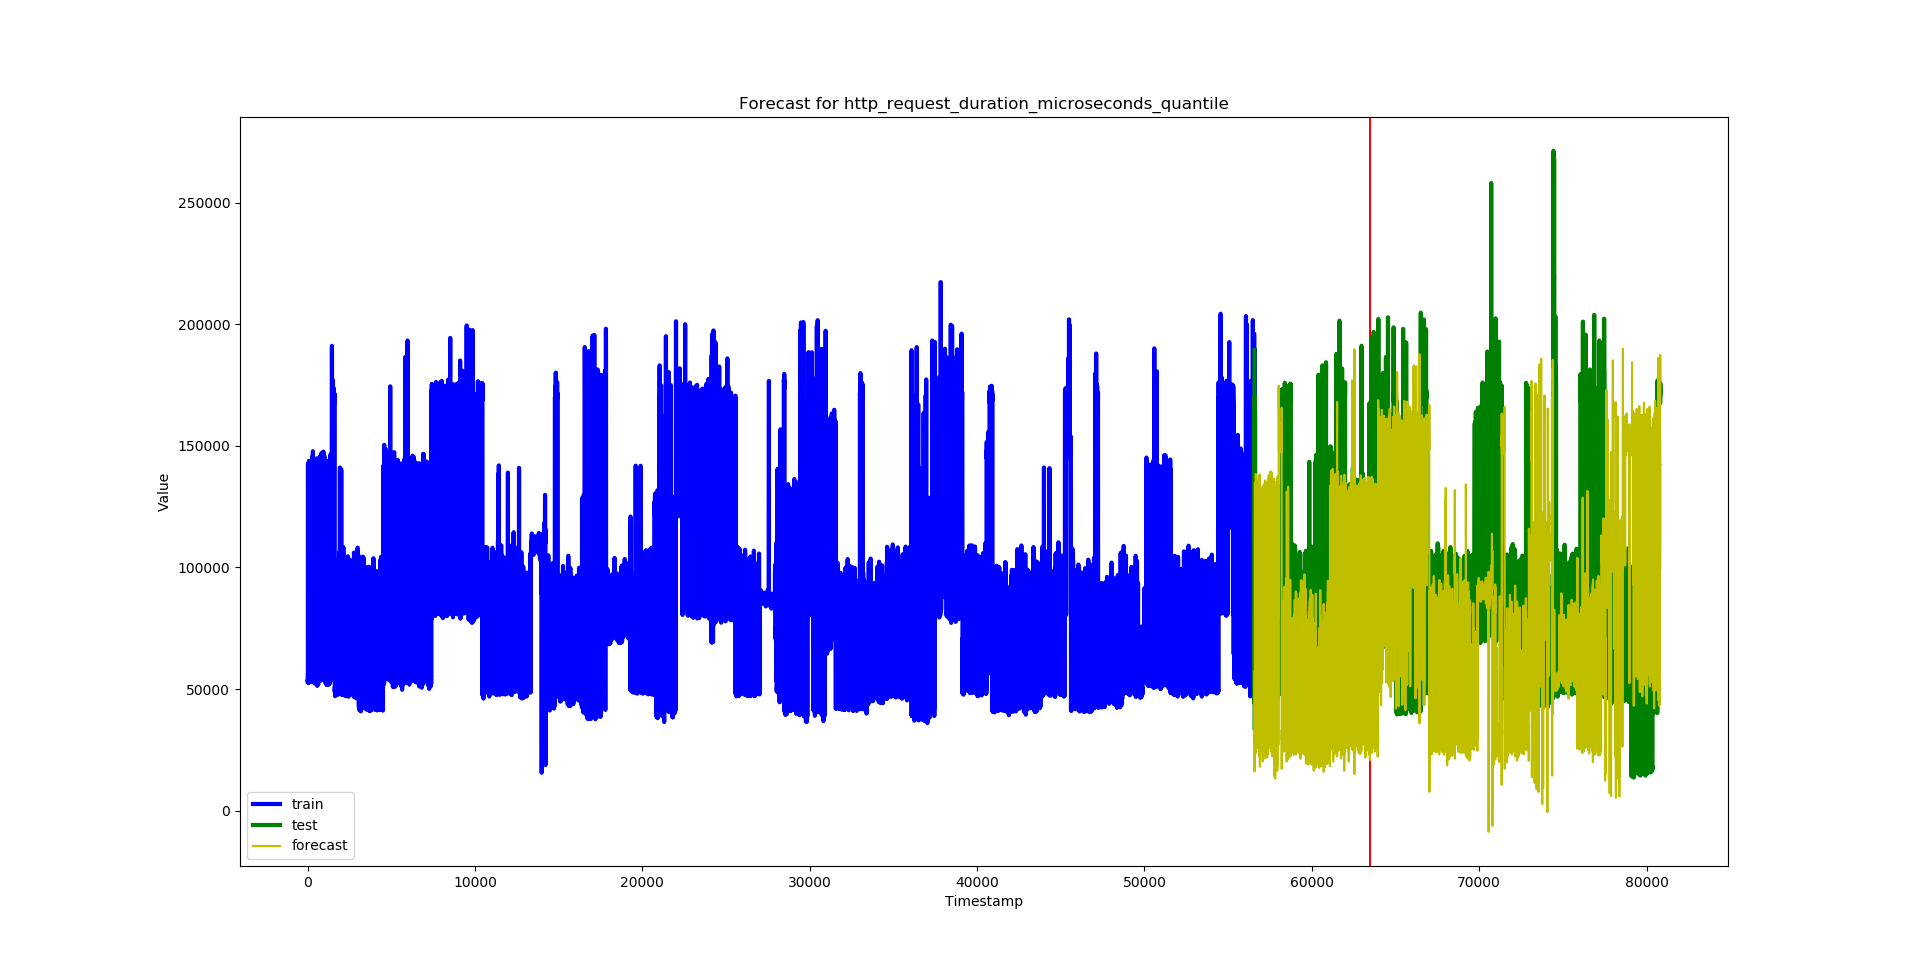

In [8]:
Image(filename='imgs/detect_anomaly_combined.png')

Please note that this is an unsupervised learning problem with hidden artifacts in the training set. Unless we have domain knowledge of the time series origin, we will not have a definitive guess on what should and should not be anomalous data. So, instead we can employ certain techniques for tuning decision threshholds.